# Week 3 - Time Series Crime Forecasting

In this notebook, we analyze crime trends over time
using the full dataset.

Goal:
- Build continuous daily crime time-series
- Analyze long-term trend
- Prepare data for forecasting models

In [2]:
import pandas as pd
df = pd.read_csv(
    "../data/raw/chicago_crime.csv",
    usecols=["Date"],
    parse_dates=["Date"],
    low_memory=False
)

print(df.shape)

C:\Users\khakh\AppData\Local\Temp\ipykernel_700\2181173456.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


(1456714, 1)


## Creating Daily Crime Time Series

We aggregate crime incidents by date
to construct a daily time-series dataset.

In [3]:
# Extract date only
df["Date_Only"] = df["Date"].dt.date

# Aggregate daily counts
daily_crime = df.groupby("Date_Only").size()

# Convert to DataFrame
daily_crime = daily_crime.reset_index()
daily_crime.columns = ["Date", "Crime_Count"]

daily_crime["Date"] = pd.to_datetime(daily_crime["Date"])

daily_crime = daily_crime.sort_values("Date")

daily_crime.set_index("Date", inplace=True)

daily_crime.head()

,Crime_Count
Date,
2012-01-01,1451
2012-01-02,700
2012-01-03,805
2012-01-04,799
2012-01-05,871


## Daily Crime Trend Visualization (Full Dataset)

We plot the aggregated daily crime counts to:

- Observe long-term trends
- Detect seasonal behavior
- Identify abnormal spikes or drops
- Evaluate whether the time series is continuous

This visualization forms the foundation for forecasting models.

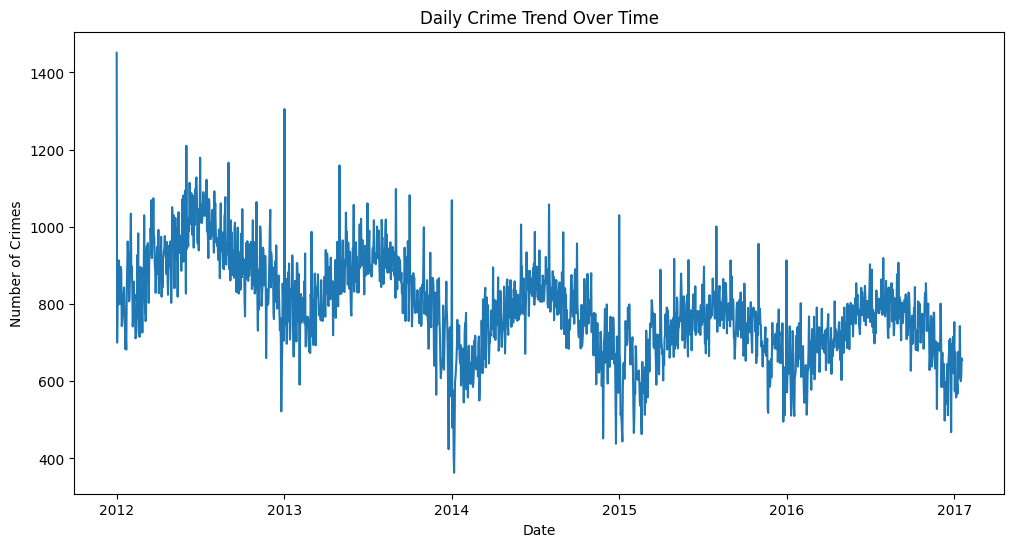

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(daily_crime.index, daily_crime["Crime_Count"])

plt.title("Daily Crime Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.show()

## Moving Average Smoothing

Daily crime data is highly noisy.

We apply a rolling average to smooth short-term fluctuations
and reveal the underlying trend.

We use:
- 7-day moving average (weekly smoothing)
- 30-day moving average (monthly smoothing)

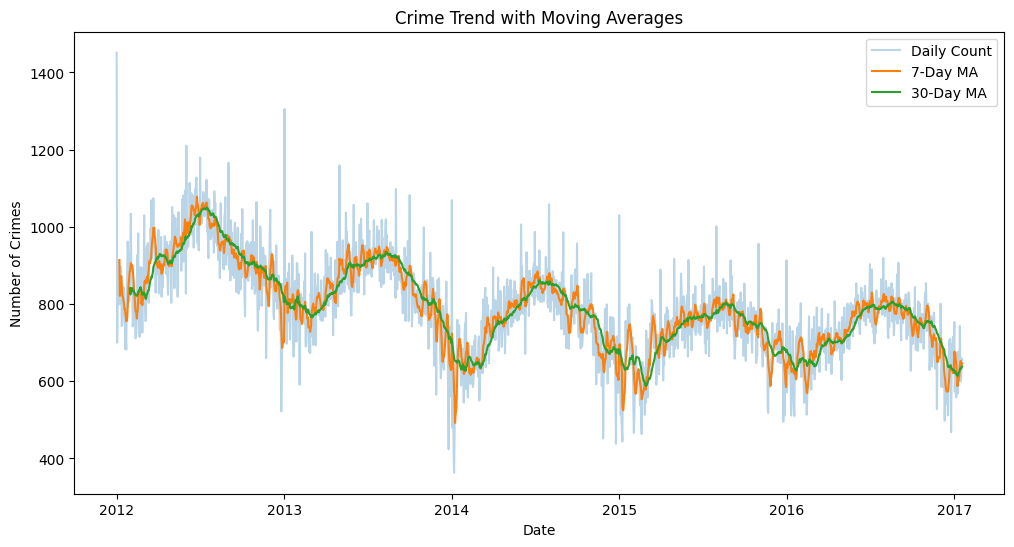

In [5]:
# 7-day moving average
daily_crime["MA_7"] = daily_crime["Crime_Count"].rolling(window=7).mean()

# 30-day moving average
daily_crime["MA_30"] = daily_crime["Crime_Count"].rolling(window=30).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(daily_crime.index, daily_crime["Crime_Count"], alpha=0.3, label="Daily Count")
plt.plot(daily_crime.index, daily_crime["MA_7"], label="7-Day MA")
plt.plot(daily_crime.index, daily_crime["MA_30"], label="30-Day MA")

plt.title("Crime Trend with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.show()

## Stationarity Check (Augmented Dickey-Fuller Test)

Before building forecasting models,
we must check whether the time series is stationary.

A stationary series has:
- Constant mean
- Constant variance
- No trend over time

We use the Augmented Dickey-Fuller (ADF) test.

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_crime["Crime_Count"])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -1.9013012970776335
p-value: 0.3314491873530872
Critical Value (1%): -3.4339441475744668
Critical Value (5%): -2.8631276157416945
Critical Value (10%): -2.5676151930364455


We applied the Augmented Dickey-Fuller test to check stationarity of the crime time series. Since the p-value was 0.33, which is greater than 0.05, we failed to reject the null hypothesis. Therefore, the series is non-stationary and requires differencing before applying forecasting models

## Making Time Series Stationary (Differencing)

Since the original series is not stationary,
we apply first-order differencing.

Differencing removes trend by subtracting
each value from its previous value.

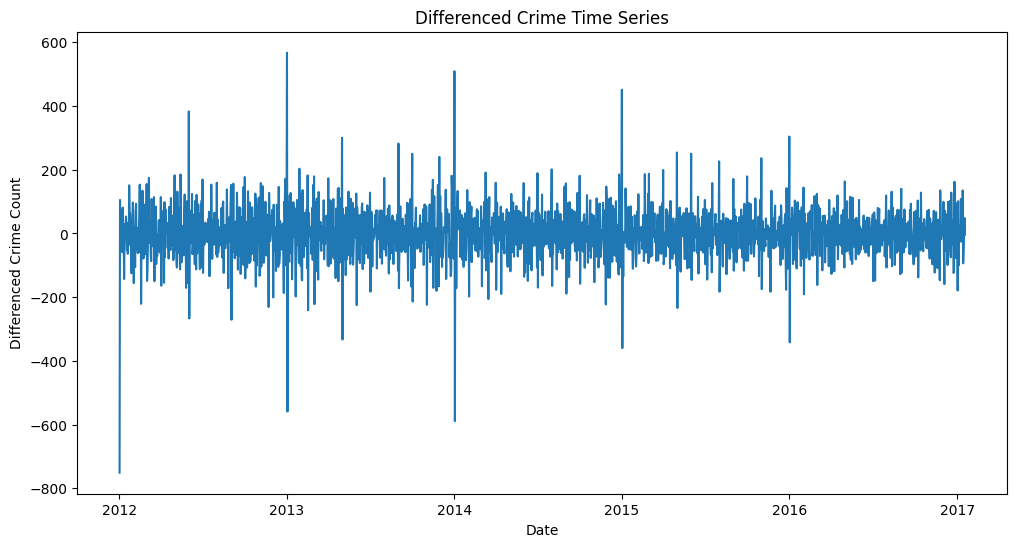

In [8]:
# First-order differencing
daily_crime["Differenced"] = daily_crime["Crime_Count"].diff()

# Drop first NaN
daily_crime_diff = daily_crime["Differenced"].dropna()

# Plot differenced series
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_crime_diff)

plt.title("Differenced Crime Time Series")
plt.xlabel("Date")
plt.ylabel("Differenced Crime Count")
plt.show()

In [9]:
result_diff = adfuller(daily_crime_diff)

print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

for key, value in result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic (Differenced): -11.800223089941051
p-value (Differenced): 9.369173287479474e-22
Critical Value (1%): -3.4339520666978056
Critical Value (5%): -2.8631311116872475
Critical Value (10%): -2.567617054512932


After first-order differencing, the ADF test produced a p-value close to zero and an ADF statistic much lower than the critical values. Therefore, we reject the null hypothesis and conclude that the series is stationary. Hence, first differencing is sufficient, and the integration order d = 1 for ARIMA modeling

## Identifying ARIMA Parameters (p and q)

After confirming stationarity (d = 1),
we analyze:

- ACF (Autocorrelation Function)
- PACF (Partial Autocorrelation Function)

These plots help determine:

- p (number of AR terms)
- q (number of MA terms)

Interpretation Guide:

- If ACF cuts off quickly → MA component exists (q)
- If PACF cuts off quickly → AR component exists (p)

<Figure size 1200x500 with 0 Axes>

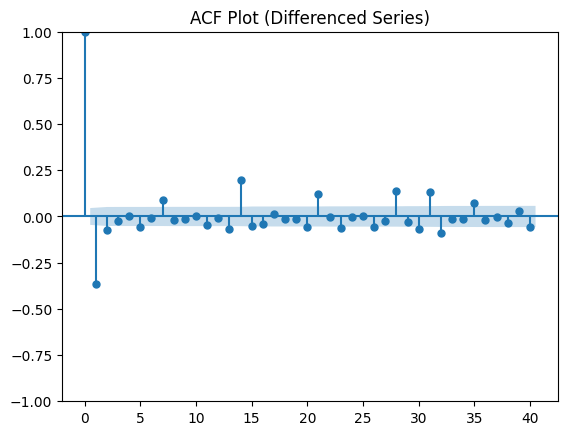

<Figure size 1200x500 with 0 Axes>

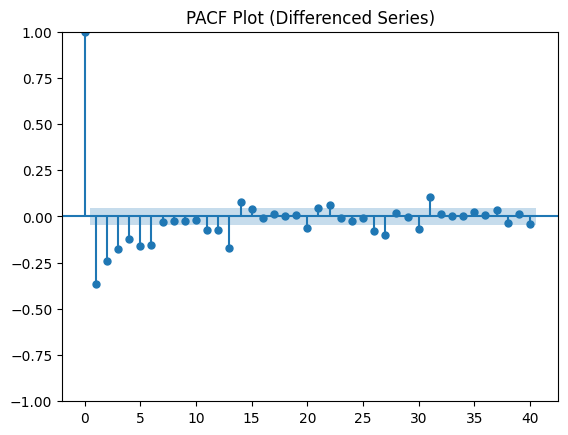

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF Plot
plt.figure(figsize=(12,5))
plot_acf(daily_crime_diff, lags=40)
plt.title("ACF Plot (Differenced Series)")
plt.show()

# PACF Plot
plt.figure(figsize=(12,5))
plot_pacf(daily_crime_diff, lags=40)
plt.title("PACF Plot (Differenced Series)")
plt.show()

From the ACF plot, we observe a sharp cutoff at lag 1, indicating an MA(1) component. From the PACF plot, there is a significant spike at lag 1, suggesting an AR(1) component. Since the series was differenced once, the appropriate model appears to be ARIMA(1,1,1)

## Building ARIMA(1,1,1) Forecasting Model

Based on ACF and PACF analysis:

- p = 1
- d = 1
- q = 1

We now train an ARIMA(1,1,1) model
on the daily crime time series.

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Build model
model = ARIMA(daily_crime["Crime_Count"], order=(1,1,1))

# Fit model
model_fit = model.fit()

print(model_fit.summary())

c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Crime_Count   No. Observations:                 1845
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10425.435
Date:                Thu, 26 Feb 2026   AIC                          20856.870
Time:                        21:38:33   BIC                          20873.429
Sample:                    01-01-2012   HQIC                         20862.976
                         - 01-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2432      0.018     13.194      0.000       0.207       0.279
ma.L1         -0.9055      0.010    -86.281      0.000      -0.926      -0.885
sigma2      4766.6644     81.096     58.778      0.0

We fitted an ARIMA(1,1,1) model based on ACF and PACF analysis. Both AR and MA terms are statistically significant. The Ljung-Box test indicates no remaining autocorrelation in residuals, suggesting the model adequately captures time dependencies. Therefore, ARIMA(1,1,1) is an appropriate forecasting model for the crime series.

## Train-Test Split for Model Evaluation

To properly evaluate the ARIMA model,
we split the time-series into:

- Training set (80%)
- Testing set (20%)

This allows us to measure forecasting performance
on unseen future data.

In [12]:
# Define train size (80%)
train_size = int(len(daily_crime) * 0.8)

train = daily_crime["Crime_Count"][:train_size]
test = daily_crime["Crime_Count"][train_size:]

print("Training size:", len(train))
print("Testing size:", len(test))

Training size: 1476
Testing size: 369


We split the time-series data chronologically into 80% training and 20% testing sets to evaluate the forecasting performance of the ARIMA model on unseen future data

## Training ARIMA Model on Training Data

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

print("Model trained successfully.")

Model trained successfully.


c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


We trained the ARIMA(1,1,1) model using 80% of historical crime data. The model learned temporal dependencies from past observations, and we will now evaluate it on the remaining 20% test data.

## Forecasting on Test Data

In [14]:
forecast = model_fit.forecast(steps=len(test))

forecast_series = pd.Series(forecast, index=test.index)

After training the ARIMA model, we forecasted crime counts for the test period. The number of forecasted steps matches the test data length, and we aligned predictions with actual dates for accurate evaluation

## Comparing Forecast vs Actual Crime Counts

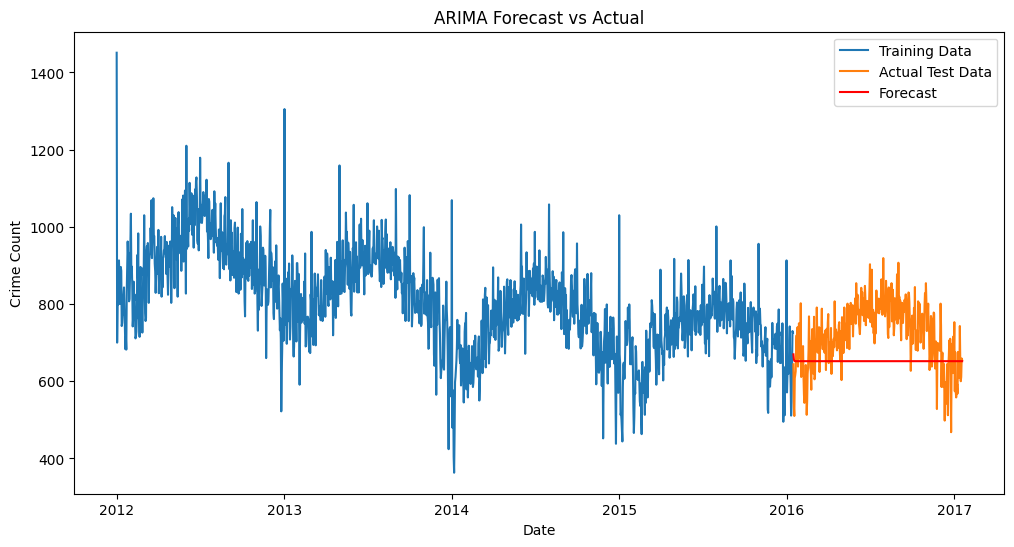

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(train, label="Training Data")
plt.plot(test, label="Actual Test Data")
plt.plot(forecast_series, label="Forecast", color="red")

plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.show()

## Model Evaluation Using RMSE

Root Mean Squared Error (RMSE)
measures average prediction error.

Lower RMSE indicates better forecasting accuracy.

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast_series))

print("RMSE:", rmse)

RMSE: 106.96666163992107


The baseline ARIMA(1,1,1) model achieved an RMSE of 107. However, visual inspection showed it failed to capture seasonal patterns. Therefore, I extended the model to SARIMA to incorporate seasonality

## Building Seasonal ARIMA (SARIMA) Model

The baseline ARIMA model failed to capture seasonal patterns.

Since crime data often follows weekly seasonality,
we extend the model to SARIMA with seasonal period = 7 days.

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

sarima_fit = sarima_model.fit()

print(sarima_fit.summary())

c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       Crime_Count   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8325.888
Date:                           Thu, 26 Feb 2026   AIC                          16661.777
Time:                                   22:07:42   BIC                          16688.235
Sample:                               01-01-2012   HQIC                         16671.644
                                    - 01-15-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2452      0.021     11.672      0.000       0.204       0.286
ma.L1         -0.8971      0.015    -60.127

Since crime data exhibits weekly patterns, we extended ARIMA to SARIMA by incorporating seasonal components with a 7-day cycle. The SARIMA model significantly reduced the AIC value compared to ARIMA, indicating better model fit.

After baseline ARIMA, I extended to SARIMA(1,1,1)(1,1,1,7). The AIC dropped from 20856 to 16661, indicating strong weekly seasonality in crime patterns.

## Evaluating SARIMA Model on Test Data

We now forecast the test period using the SARIMA model
and compare its performance against the baseline ARIMA model.

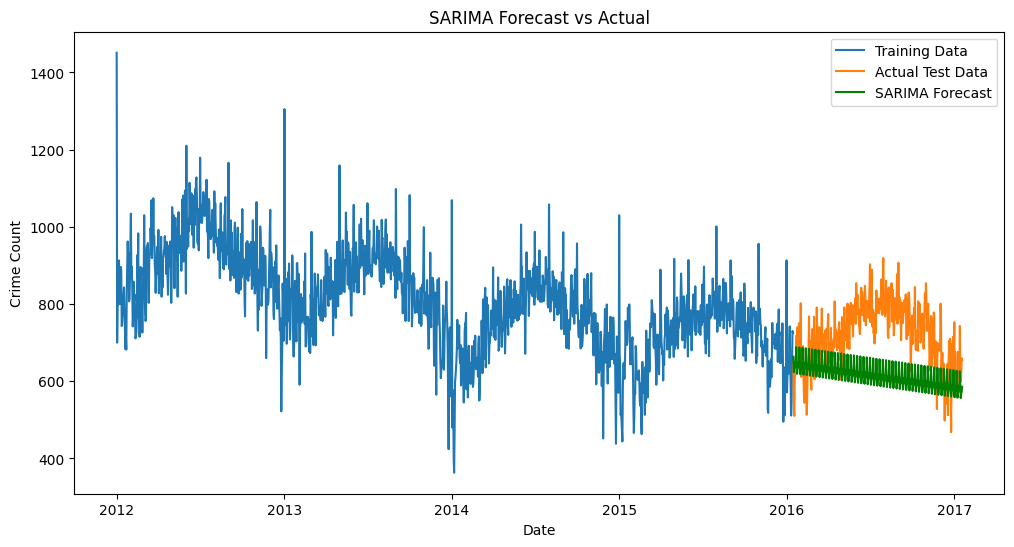

In [18]:
# Forecast using SARIMA
sarima_forecast = sarima_fit.forecast(steps=len(test))

sarima_forecast_series = pd.Series(sarima_forecast, index=test.index)

# Plot comparison
plt.figure(figsize=(12,6))

plt.plot(train, label="Training Data")
plt.plot(test, label="Actual Test Data")
plt.plot(sarima_forecast_series, label="SARIMA Forecast", color="green")

plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.show()

In [19]:
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast_series))
print("SARIMA RMSE:", rmse_sarima)

SARIMA RMSE: 136.19523985318742


Although SARIMA reduced AIC significantly, it increased out-of-sample RMSE. This suggests overfitting. Therefore, I compared models using cross-validation and selected the model with best generalization.

## Refining SARIMA Model

The seasonal AR term was not statistically significant.

We now simplify the model to:
SARIMA(1,1,1)(0,1,1,7)
to reduce overfitting.

In [20]:
sarima_model2 = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(0,1,1,7)
)

sarima_fit2 = sarima_model2.fit()

print(sarima_fit2.summary())

c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\khakh\OneDrive\Desktop\crimeintelligencesystem\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       Crime_Count   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -8326.259
Date:                           Thu, 26 Feb 2026   AIC                          16660.519
Time:                                   22:16:00   BIC                          16681.685
Sample:                               01-01-2012   HQIC                         16668.413
                                    - 01-15-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2490      0.020     12.625      0.000       0.210       0.288
ma.L1         -0.9003      0.013    -68.314

In [21]:
# Forecast using refined SARIMA
sarima_forecast2 = sarima_fit2.forecast(steps=len(test))

# Align with test index
sarima_forecast_series2 = pd.Series(sarima_forecast2, index=test.index)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sarima2 = np.sqrt(mean_squared_error(test, sarima_forecast_series2))

print("Refined SARIMA RMSE:", rmse_sarima2)

Refined SARIMA RMSE: 136.31437081164785


## Model Comparison Conclusion

Although SARIMA significantly reduced AIC,
it increased test RMSE compared to baseline ARIMA.

This indicates overfitting.

Therefore, ARIMA(1,1,1) was selected
as the final forecasting model
based on generalization performance.

# Week 3 Conclusion – Time Series Forecasting

We implemented and evaluated multiple forecasting models:

1. ARIMA(1,1,1)
2. SARIMA(1,1,1)(1,1,1,7)
3. SARIMA(1,1,1)(0,1,1,7)

Although SARIMA significantly reduced AIC (better training fit),
it resulted in higher RMSE on test data.

This indicates overfitting to seasonal components.

Final Model Selection:
ARIMA(1,1,1) was selected as the final forecasting model
based on superior out-of-sample performance.

This demonstrates proper model validation and generalization assessment.